# Static modelling

<ul>
<li>Explore statistical correlation between different parameters</li>
<li>ML to get static condition</li>
<li>Deep learning to test $Head$ in terms of pump speed and  $head$</li>
</ul>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

## 1A. Load data from google drive

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1B. Load data from local drive

In [3]:
#import io
#df = pd.read_csv(io.StringIO(uploaded['vattenfall_turbine.csv'].decode('utf-8')))

df = pd.read_csv(r'C:\Users\wengang\OneDrive - Chalmers\2021_Vattenfall\vattenfall_turbine.csv')
keys = df.dtypes.index[1:11]
df_data = df[df.dtypes.index[1:10]]

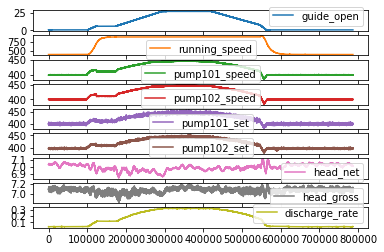

In [4]:
df_data.plot(subplots=True)
#plt.tight_layout()
plt.show()

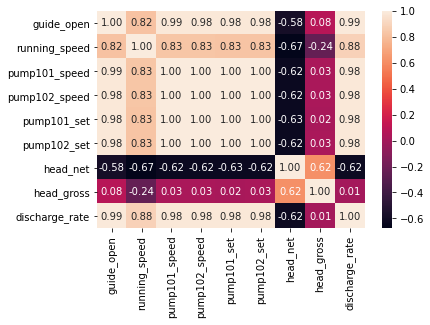

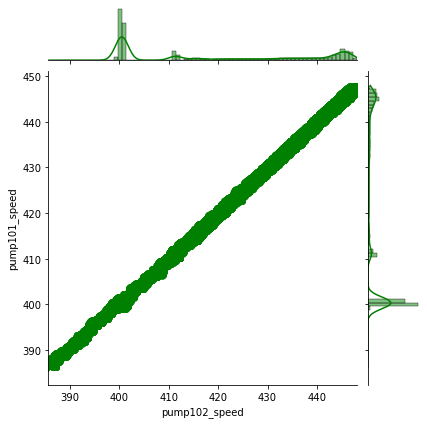

In [5]:
#sns.lmplot(df.dtypes.index[1],df.dtypes.index[2], data=df, fit_reg=False)

sns.heatmap(df_data.corr(), annot=True, fmt=".2f")
plt.show()

sns.jointplot(data=df_data, x='pump102_speed', y='pump101_speed', kind='reg', color='g')
plt.show()

## 2, Use various static ML methods to derive models for Head_g

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


import xgboost as xgb

### **2.1, XGBoost model**

The time used to find the optimal solution is 79.16086387634277 seconds
-0.0015027951597700983
{'gamma': 5, 'learning_rate': 0.15, 'max_depth': 16, 'subsample': 0.8}


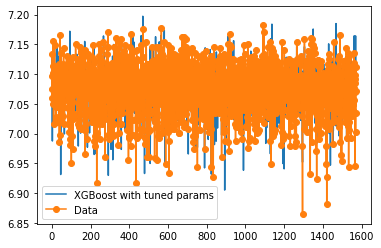

In [7]:
# Prepare for the data
df_data.dropna()
resolution = 100
df_data1 = df_data.iloc[::resolution]

df_features = df_data1[df_data.keys()[[0, 2, 3, 8]]]
df_target = df_data1[['head_gross']]
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size = 0.2)
y_test = np.sort(y_test)

# Find the optimal parameters for the XGBoost modelling
params_fix = {'objective':'reg:squarederror', 
              'nthread': -1, 
              'colsample_bytree': 0.99, 
              'min_child_weight': 5.0, 
              'n_estimators': 100
    }
params = {'learning_rate': [0.1, 0.15],
        'gamma': [5, 6, 7],
        #'reg_alpha': 149.79,
        'subsample': [0.8, 0.9],
        'max_depth': [16, 19]
    }

params_best = {'learning_rate': 0.15,
        'gamma': 5,
        #'reg_alpha': 149.79,
        'subsample': 0.9,
        'max_depth': 16
    }


xgb_reg = xgb.XGBRegressor(**params_fix)

import time
start = time.time()
xgb_models = GridSearchCV(xgb_reg, params).fit(X_train,y_train)
params_best = xgb_models.best_params_
end = time.time()
time_cost = end - start
print(f'The time used to find the optimal solution is {time_cost} seconds')


# Print the best model parameters: NB one should use it in the following analysis
xgb_models.fit(X_train, y_train)
print(xgb_models.best_score_)
print(xgb_models.best_params_)

# Use best parameters to fit the XGBoost model
model_xgb = xgb.XGBRegressor(max_depth = 16, learning_rate = 0.1, gamma= 0, subsample=0.8, colsample_bytree = 0.1, n_estimators = 1000)
model_xgb.fit(X_train, y_train)

# Prediction and model assessment by MSE and R2
predictions_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(predictions_xgb,y_test)
r2_xgb = r2_score(predictions_xgb,y_test)

# Plot the results
plt.figure()
plt.plot(predictions_xgb, label = "XGBoost with tuned params")
plt.plot(y_test,'-o',  label = "Data")
plt.legend()


### **2.2, Neural Network Model**

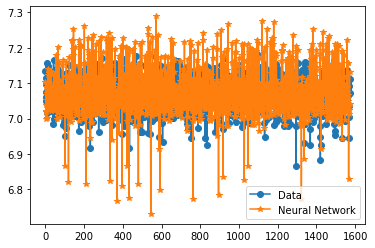

In [9]:
model_nn = MLPRegressor(hidden_layer_sizes=(50,),solver ="lbfgs", random_state=9)

model_nn.fit(X_train,y_train.values.ravel())

predictions_nn = model_nn.predict(X_test)

error_nn = mean_squared_error(predictions_nn, y_test)


# Prediction and model assessment by MSE and R2
mse_nn = mean_squared_error(predictions_nn,y_test)
r2_nn = r2_score(predictions_nn,y_test)

#### Plots of results ####
plt.figure()

plt.plot(y_test,'-o',  label = "Data")

plt.plot(predictions_nn,'-*', label = "Neural Network")
plt.legend()


### **2.3, Ada random forest model**

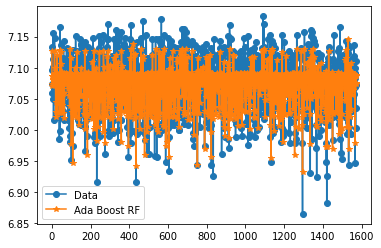

In [10]:
#### Ada Boosted Decision Tree ####

# Initialize the model with some parameters.
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300)
# Fit the model to the data.
model_ada.fit(X_train,y_train.values.ravel())
# Make predictions.
predictions_ada = model_ada.predict(X_test)
# Compute the error.
error_ada = mean_squared_error(predictions_ada, y_test)


# Prediction and model assessment by MSE and R2
mse_ada = mean_squared_error(predictions_ada,y_test)
r2_ada = r2_score(predictions_ada,y_test)


#### Plots of results ####
plt.figure()
plt.plot(y_test,'-o',  label = "Data")
plt.plot(predictions_ada,'-*', label = "Ada Boost RF")
plt.legend()

### **2.4, Poly nominal regression model**

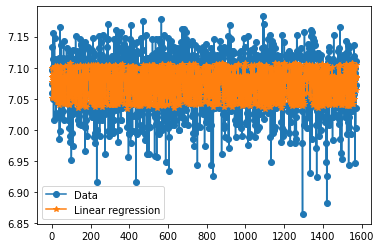

In [11]:
model_lin = LinearRegression()

model_lin.fit(X_train,y_train)

predictions_lin = model_lin.predict(X_test)

error = mean_squared_error(predictions_lin, y_test) # Mean squared error

score = model_lin.score(X_test,y_test)              # Variance / score

# Prediction and model assessment by MSE and R2
mse_lin = mean_squared_error(predictions_lin,y_test)
r2_lin = r2_score(predictions_lin,y_test)


#### Plots of results ####
plt.figure()
plt.plot(y_test,'-o',  label = "Data")
plt.plot(predictions_lin,'-*', label = "Linear regression")
plt.legend()


## **3, Summary of the results and output of data for matlab plot**

In [20]:
# Print the goodness of all the models
print(f'R2 of different models.\n The xgboost model: {r2_xgb};\n The neural network model: {r2_nn};\n The ada boost RF model: {r2_ada};\n The linear regression model: {r2_lin}. ')


# NB: OPTIONAL -- save results to Mat file for better plotting
from scipy import io

head_obs = y_test
head_xgb = model_xgb.predict(X_test)

head_nn = model_nn.predict(X_test)
head_ada = model_ada.predict(X_test)
head_lin = model_lin.predict(X_test)

io.savemat('head_data.mat', {'head_obs':head_obs,'head_xgb':head_xgb,'head_nn':head_nn,'head_ada':head_ada,'head_lin':head_lin})


R2 of different models.
 The xgboost model: 0.1678369777863331;
 The neural network model: -0.842166034311792;
 The ada boost RF model: 0.03646914777986854;
 The linear regression model: -2.7208236624984203. 
